In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.patches import Rectangle
from scipy.sparse import coo_matrix
from itertools import combinations
from itertools import product


In [2]:
from google.colab import drive
drive.mount("/content/drive")

%cd /content/drive/MyDrive/'Bioinformatics Project'

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1M3r0dTc1ZOtYqjXf6O9h_xvcWvCX_IXa/Bioinformatics Project


In [3]:
import_control_path = "chr_dfs/chr5_control_tads.csv"
import_condition_path = "chr_dfs/chr5_condition_tads.csv"

In [4]:
control_tads = pd.read_csv(import_control_path, index_col=False)
condition_tads = pd.read_csv(import_condition_path, index_col=False)
control_tads_list = np.array([list(tuple(row)) for row in control_tads[['start', 'end']].to_numpy().tolist()])
condition_tads_list = np.array([list(tuple(row)) for row in condition_tads[['start', 'end']].to_numpy().tolist()])
tads_lists = [control_tads_list, condition_tads_list]

In [5]:
def GetPlotTads(tad_coords_list):
    tads_for_plotting = []
    for row in tad_coords_list:
        curr_tuple = ()
        inner_start = (row[0], row[0])
        inner_end = (row[1], row[1])
        curr_tuple = (inner_start, inner_end)
        tads_for_plotting.append(curr_tuple)
    return tads_for_plotting

In [6]:

def PlotHeatmap(ctrl_coord_ranges, cndn_coord_ranges, chr_num, x_max=None, y_max=None):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Set axis limits based on maximum coordinates
    if x_max is not None and y_max is not None:
        ax.set_xlim(0, x_max)
        ax.set_ylim(0, y_max)

    # Iterate through coordinate ranges and draw rectangles
    for start, end in ctrl_coord_ranges:
        x_length = (end[0] - start[0]) * 25
        y_length = (end[1] - start[1]) * 25
        rectangle = Rectangle((start[0], start[1]), x_length, y_length, edgecolor='none', facecolor='blue', alpha=0.3)
        ax.add_patch(rectangle)
    for start, end in cndn_coord_ranges:
        x_length = (end[0] - start[0]) * 25
        y_length = (end[1] - start[1]) * 25
        rectangle = Rectangle((start[0], start[1]), x_length, y_length, edgecolor='none', facecolor='red', alpha=0.1)
        ax.add_patch(rectangle)

    # Set labels and title
    ax.set_xlabel('Position (BP)')
    ax.set_ylabel('Position (BP)')
    ax.set_title('Chromosome '+str(chr_num)+': TADs')
    plt.savefig('tad chr'+str(chr_num)+'_plot.png')

    # Show plot
    plt.show()

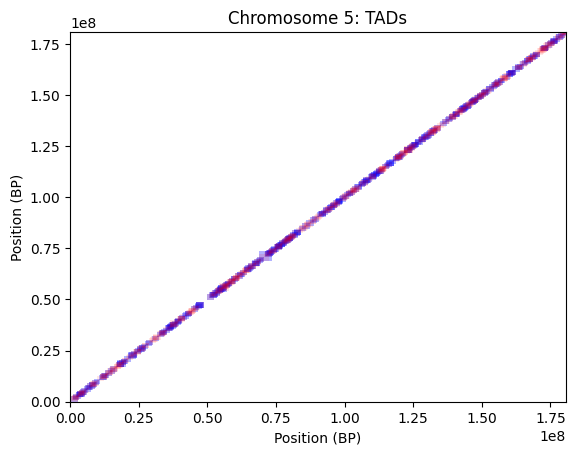

In [ ]:
ctrl_tads_list = []
cndn_tads_list = []
for row in control_tads_list:
    ctrl_tads_list.append((row[0], row[1]))
# cndn_tads_list = []
for row in condition_tads_list:
    cndn_tads_list.append((row[0], row[1]))
ctrl_tads_for_plotting = GetPlotTads(ctrl_tads_list)
cndn_tads_for_plotting = GetPlotTads(cndn_tads_list)
PlotHeatmap(ctrl_tads_for_plotting, cndn_tads_for_plotting, 5, ctrl_tads_for_plotting[-1][-1][-1], ctrl_tads_for_plotting[-1][-1][-1])

In [42]:
def CropTadsLists(tads_list, start, end):
    start_index = 0
    end_index = len(tads_list)-1
    if tads_list[-1][1] < start or tads_list[0][0] > end: # if tads_list is completely outside of start/end, return empty list
        return []

    for i, row in enumerate(tads_list):
        # if row[1] < start: # start is after the row (before we reach start)
        #     continue
        if row[1] >= start and  row[0] <= start: # start is within the row (while we are at start)
            row[0] = start
            start_index = i
        # elif row[0] > start: # start is behind the row (already completely passed start)
        #     continue
        if row[0] <= end and row[1] >= end:
            row[1] = end
            end_index = i

    return tads_list[start_index:end_index+1]

'''
CropTadLists: takes given start-to-end subset of tadlist (and leave out the start)
'''
def CropTadLists(tad_list, start, end):

    print("crop tad: tad list")
    print(tad_list)
    print("start, end", start, end)

    cropped_tads_list = []
    tad_list = np.array(tad_list)

    target_positions = np.where((tad_list >= start) & (tad_list <= end), 1, 0)


    for i, tads in enumerate(tad_list):
        cropped_tads_row = []
        for j, tad in enumerate(tads):
            if target_positions[i][j] == 1:
                cropped_tads_row.append(tad_list[i][j])
        if len(cropped_tads_row) > 0:
            cropped_tads_list.append(cropped_tads_row)

    print("cropped tad list")
    print(cropped_tads_list)
    return cropped_tads_list


In [38]:
def ProduceTADLists(tads_lists):
    vi_list = []
    tads_coords_list = []
    for i, tads_list in enumerate(tads_lists):
        for j, tads in enumerate(tads_list):
            tads_start, tads_end = tads[0], tads[1]

            print("tad starts", tads_start)
            # curr_boundary.start = tads_start
            # curr_boundary.end = tads_end
            # n = tads_end - tads_start + 1
            #target_tads_1 = CropTadLists(tad_lists[0], tads
            #overlaps = FindOverlaps(target_)
            n = tads_end - tads_start + 1
            target_tads_1 = CropTadsLists(tads_lists[0], tads_start, tads_end)
            target_tads_2 = CropTadsLists(tads_lists[1], tads_start, tads_end)
            #print(target_tads_1)
            #print(target_tads_2)
            overlaps = FindOverlaps(target_tads_1, target_tads_2)

            cluster1_lengths = np.zeros(len(target_tads_1))
            for i, cluster in enumerate(target_tads_1):
                cluster1_lengths[i] = cluster[1]-cluster[0]+1
            cluster2_lengths = np.zeros(len(target_tads_2))
            for i, cluster in enumerate(target_tads_2):
                cluster2_lengths[i] = cluster[1]-cluster[0]+1

            # curr_h1_cond = ConditionalEntropy(Transpose(overlaps), cluster1_lengths, n)
            # curr_h2_cond = ConditionalEntropy(overlaps, cluster2_lengths, n) #NOT USED??? can remove from conditional entropy class????
            vi = ComputeVI(overlaps, cluster1_lengths, cluster2_lengths, n) # IS THIS RIGHT???
            tads_coords_list.append((tads_start, tads_end))
            vi_list.append(vi)
    print('VI Sum:', np.sum(vi_list))
    return tads_coords_list, vi_list
            # curr_cond_entropy.condh1 = ConditionalEntropy(Transpose(overlaps), cluster1_lengths, n)
            # curr_cond_entropy.condh2 = ConditionalEntropy(overlaps, cluster2_lengths, n) #NOT USED??? can remove from conditional entropy class????
            # curr_cond_entropy.vi = ComputeVI(overlaps, cluster1_lengths, cluster2_lengths, n)

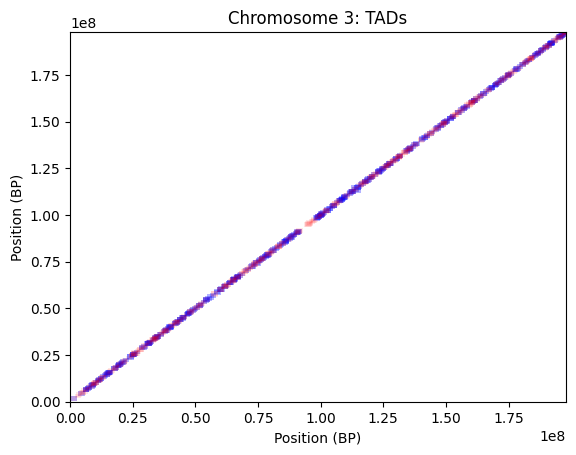

In [ ]:
# Is this actually the chromosome 3 tads? We used the same csv...
    # This should be fixed now

import_control_path = "chr_dfs/chr3_control_tads.csv"
import_condition_path = "chr_dfs/chr3_condition_tads.csv"

control_tads_3 = pd.read_csv(import_control_path, index_col=False)
condition_tads_3 = pd.read_csv(import_condition_path, index_col=False)
control_tads_list_3 = np.array([list(tuple(row)) for row in control_tads_3[['start', 'end']].to_numpy().tolist()])
condition_tads_list_3 = np.array([list(tuple(row)) for row in condition_tads_3[['start', 'end']].to_numpy().tolist()])
tads_lists_3 = [control_tads_list_3, condition_tads_list_3]

ctrl_tads_list_3 = []
for row in control_tads_list_3:
    ctrl_tads_list_3.append((row[0], row[1]))
cndn_tads_list_3 = []
for row in condition_tads_list_3:
    cndn_tads_list_3.append((row[0], row[1]))
ctrl_tads_for_plotting_3 = GetPlotTads(ctrl_tads_list_3)
cndn_tads_for_plotting_3 = GetPlotTads(cndn_tads_list_3)
PlotHeatmap(ctrl_tads_for_plotting_3, cndn_tads_for_plotting_3, 3, ctrl_tads_for_plotting_3[-1][-1][-1], ctrl_tads_for_plotting_3[-1][-1][-1])

In [32]:
'''
FindOverlaps: finds the overlapping regions between two lists of clusters
'''
def FindOverlaps(clusters1, clusters2):

    print("clusters1")
    print(clusters1)
    print("clusters2")
    print(clusters2)
    overlap_matrix = []
    # range through each pair of clusters between the two lists of clusters
    for i, cluster1 in enumerate(clusters1):
        overlap_matrix.append([-1]*len(clusters2)) # initialization, may need to change later (each row may have diff lengths? matrix might not be guaranteed square?)
        for j, cluster2 in enumerate(clusters2):
            cl1_start, cl1_end, cl2_start, cl2_end = cluster1[0], cluster1[1], cluster2[0], cluster2[1]
            if cl1_start > cl2_end or cl2_start > cl1_end:
                overlap_matrix[i][j] = 0
            elif cl1_start <= cl2_start:
                if cl1_end >= cl2_end: # cluster 2 encased in cluster 1
                    overlap_matrix[i][j] = cl2_end - cl2_start + 1
                else: # overlap between end of cluster 1 and start of cluster 2
                    overlap_matrix[i][j] = cl1_end - cl2_start + 1
            else: # cl1 start > cl2 start
                if cl1_end <= cl2_end: # cluster 1 encased in cluster 2
                    overlap_matrix[i][j] = cl1_end - cl1_start + 1
                else: # overlap between end of cluster 2 and start of cluster 1
                    overlap_matrix[i][j] = cl2_end - cl1_start + 1

    print("overlap matrix")
    print(overlap_matrix)


    return overlap_matrix

'''
ComputeVI: computes the variation of information (VI) of the given two clusterings (and given n)
'''
def ComputeVI(overlap_matrix, clustering1, clustering2, n):
    hc1 = ConditionalEntropy(Transpose(overlap_matrix), clustering1, n)
    hc2 = ConditionalEntropy(overlap_matrix, clustering2, n)
    assert n > 0
    vi = (hc1 + hc2) / math.log(n)

    if np.isnan(vi):
      print("hc1", hc1, "hc2", hc1, "n", n)

    return vi

'''
Conditional Entropy: computes conditional entropy of target cluster
inputs: overlaps = overlapping regions between the clusters (matrix)
        cluster_lengths = list of sizes of each cluster (list, with length size equal to number of clusters?)
        n = denominator of conditional entropy calculation (float, should be log(n)?)
output: conditonal entropy of target cluster (float64)
'''
def ConditionalEntropy(overlap_matrix, cluster_lengths, n):
    cond_entropy = 0
    for i, row in enumerate(overlap_matrix):
        for j, cell in enumerate(row):
            cluster_length = cluster_lengths[j]
            #print('hi:', cell * math.log(cluster_length))
            cond_entropy += cell * math.log(cluster_length)
            if cell != 0:
                #print('minus:', -1 * cell * math.log(cell))
                cond_entropy += -1 * cell * math.log(cell)
                #print('himinus:', cond_entropy, cell, math.log(cell))
        #print('hic:', cond_entropy)
    cond_entropy /= n
    return cond_entropy

'''
Transpose: can work for any "matrix" (can be non-rectangular)
'''
def Transpose(matrix):
    longest_row = 0
    for row in matrix:
        length = len(row)
        if length > longest_row:
            longest_row = length

    matrix_t = []
    for j in range(longest_row):
        row_t = []
        for _, row in enumerate(matrix):
            if j < len(row):
                row_t.append(row[j])
        matrix_t.append(row_t)
    return matrix_t


In [31]:
print(len(tads_lists[1][2]))

TypeError: object of type 'numpy.int64' has no len()

In [34]:
test_tad_lists = [tads_lists[0][1:10], tads_lists[1][1:10]]

In [43]:
tads_coords_list, vi_list = ProduceTADLists(test_tad_lists)
tads_for_plotting = GetPlotTads(tads_coords_list)
# Plot the heatmap
# PlotHeatmap(tads_for_plotting, 3, tads_for_plotting[-1][-1][-1], tads_for_plotting[-1][-1][-1])
# Why is the VI sum nan here?

tad starts 920000
clusters1
[[ 920000 1020000]]
clusters2
[[ 170000  200000]
 [ 600000  700000]
 [ 760000  860000]
 [1200000 1280000]
 [1660000 1770000]
 [2410000 2510000]
 [2770000 2870000]
 [2930000 3030000]
 [3140000 3250000]]
overlap matrix
[[0, 0, 0, 0, 0, 0, 0, 0, 0]]
tad starts 1200000
clusters1
[[1200000 1280000]]
clusters2
[[1200000 1280000]]
overlap matrix
[[80001]]
tad starts 2260000
clusters1
[[2260000 2270000]]
clusters2
[[ 170000  200000]
 [ 600000  700000]
 [ 760000  860000]
 [1200000 1280000]
 [1660000 1770000]
 [2410000 2510000]
 [2770000 2870000]
 [2930000 3030000]
 [3140000 3250000]]
overlap matrix
[[0, 0, 0, 0, 0, 0, 0, 0, 0]]
tad starts 2260000
clusters1
[[2260000 2270000]]
clusters2
[[ 170000  200000]
 [ 600000  700000]
 [ 760000  860000]
 [1200000 1280000]
 [1660000 1770000]
 [2410000 2510000]
 [2770000 2870000]
 [2930000 3030000]
 [3140000 3250000]]
overlap matrix
[[0, 0, 0, 0, 0, 0, 0, 0, 0]]
tad starts 2410000
clusters1
[[2410000 2510000]]
clusters2
[[2410000 

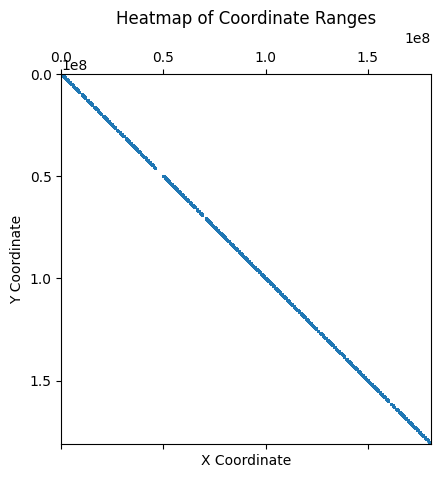

In [ ]:

# Example list of tuples representing coordinate ranges
coord_ranges = tads_coords_list.copy()

# Extract start and end coordinates from the tuples
start_coords, end_coords = zip(*coord_ranges)

x_max = None
y_max = None
# Determine the maximum x and y coordinates
if x_max is None:
    x_max = max(max(start, end) for (start, end) in coord_ranges)
if y_max is None:
    y_max = max(max(start, end) for (start, end) in coord_ranges)

# Create a COO sparse matrix
row = []
col = []
data = []
for (start, end) in coord_ranges:
    row.extend(range(start, end + 1))
    col.extend(range(start, end + 1))
    data.extend([1] * (end - start + 1))

# Create the sparse matrix
heatmap_sparse = coo_matrix((data, (row, col)), shape=(x_max + 1, y_max + 1))

# Convert to a dense matrix for plotting
#heatmap_dense = heatmap_sparse.toarray()

plt.spy(heatmap_sparse, markersize=1)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Coordinate Ranges')
plt.show()


In [ ]:
for i in range(10):
  print((tads_coords_list)[i])

(90000, 120000)
(920000, 1020000)
(1200000, 1280000)
(2260000, 2270000)
(2260000, 2270000)
(2410000, 2510000)
(2650000, 2660000)
(2650000, 2660000)
(3470000, 3480000)
(3470000, 3480000)


In [ ]:
intervals = np.arange(0,197920000, 10000)
intervals

array([        0,     10000,     20000, ..., 197890000, 197900000,
       197910000])

In [ ]:
# Example list of values

# Can't do it this way due to memory issues (pairwise combination of TADs)

# Generate combinations of two values with possible duplicates
# combinations_list = list(product(intervals, repeat=2))

# Convert to DataFrame
# df = pd.DataFrame(combinations_list, columns=['mat1', 'mat2'])

# print(df)

In [ ]:
# Example list of values
values = ['A', 'B', 'C', 'D', 'E']

# Generate combinations of two values with possible duplicates
combinations_list = list(product(values, repeat=2))

# Convert to DataFrame
df = pd.DataFrame(combinations_list, columns=['Value1', 'Value2'])

print(df)

   Value1 Value2
0       A      A
1       A      B
2       A      C
3       A      D
4       A      E
5       B      A
6       B      B
7       B      C
8       B      D
9       B      E
10      C      A
11      C      B
12      C      C
13      C      D
14      C      E
15      D      A
16      D      B
17      D      C
18      D      D
19      D      E
20      E      A
21      E      B
22      E      C
23      E      D
24      E      E


In [ ]:
'''
Boundary VI Class:
start = start position of TAD boundary
end = end position of TAD boundary
vi = variation of information metric (how similar it is between its two clusterings)
pval = the signifiance of this variation difference
'''
class Boundary:
    start = -1
    end = -1
    vi = -1.0
    pval = -1.0


'''
Conditional Entropy Class:
vi = variation of information metric
condh1 = conditional entropy around first cluster
condh2 = conditiona entropy around second cluster
'''
class Cond_Entropy:
    vi = -1.0
    condh1 = -1.0
    condh2 = -1.0

In [ ]:
tl = np.array([[13,16,18,19], [20,21,24,25], [28,32,37,38]])
s = 21
e = 35
#targets = np.where((tl >= 20) & (tl <= 35), 1, 0)
print(CropTadLists(tl, s, e))
print(CropTadsLists(tl, s, e))

[[21, 24, 25], [28, 32]]
[[21 21 24 25]
 [28 32 37 38]]


In [44]:
'''
ToDo: Implement dynamic programing part of computing VI for tad boundaries (section 2.3 of paper)
outputs lists of VI scores at each TAD boundary
'''
def Compute_VI_of_TAD_Boundaries(tad_lists):
    # initializations (TAD boundary list for holding VIs)

    # set up dominant point maps....

    # conditional entropy scores

    for i, tad_list in enumerate(tad_lists):
        for j, tads in enumerate(tad_list):
            curr_boundary = Boundary()
            tads_start, tads_end = tads[0], tads[1]
            curr_boundary.start = tads_start
            curr_boundary.end = tads_end
            n = tads_end - tads_start + 1
            target_tads_1 = CropTadLists(tad_lists[0], tads_start, tads_end)
            target_tads_2 = CropTadLists(tad_lists[1], tads_start, tads_end)
            overlaps = FindOverlaps(target_tads_1, target_tads_2)

            cluster1_lengths = np.zeros(len(target_tads_1))
            for i, cluster in enumerate(target_tads_1):
                cluster1_lengths[i] = cluster[1]-cluster[0]+1
            cluster2_lengths = np.zeros(len(target_tads_2))
            for i, cluster in enumerate(target_tads_2):
                cluster2_lengths[i] = cluster[1]-cluster[0]+1

            # curr_cond_entropy.condh1 = ConditionalEntropy(Transpose(overlaps), cluster1_lengths, n)
            # curr_cond_entropy.condh2 = ConditionalEntropy(overlaps, cluster2_lengths, n) #NOT USED??? can remove from conditional entropy class????
            curr_cond_entropy.vi = ComputeVI(overlaps, cluster1_lengths, cluster2_lengths, n)

            '''
            check if we really need object for conditional entropy (condh1 and condh2 are already computed in ComputeVI function (and are they only used there????))
            --update okay, they may be useful.....
            ----> may want to split computeVI function to make sure we get the condh computed values attached to the condtional entropy objects
            add to dp map if applicable!!!!
             '''
            boundary_vi_list.append(curr_cond_entropy.vi)

    return boundary_vi_list


'''
process intervals...
compute overlaps...
create cluster sizes (for each of the 2 clusterings?)
compute the conditional entropies
compute the VIs
add to dominant point map mapping
update the new boundary VI (if applicable...???)
update the new boundary VI list....'''
print()

# main function
def ProduceSigTads(tads_lists):
    vi_list = []
    tads_coords_list = []

    for i, tads_list in enumerate(tads_lists):
        for j, tads in enumerate(tads_list):
            tads_start, tads_end = tads[0], tads[1]
            # curr_boundary.start = tads_start
            # curr_boundary.end = tads_end
            # n = tads_end - tads_start + 1
            #target_tads_1 = CropTadLists(tad_lists[0], tads
            #overlaps = FindOverlaps(target_)
            n = tads_end - tads_start + 1
            target_tads_1 = CropTadsLists(tads_lists[0], tads_start, tads_end)
            target_tads_2 = CropTadsLists(tads_lists[1], tads_start, tads_end)
            # print(target_tads_1)
            # print(target_tads_2)
            overlaps = FindOverlaps(target_tads_1, target_tads_2)

            cluster1_lengths = np.zeros(len(target_tads_1))
            for i, cluster in enumerate(target_tads_1):
                cluster1_lengths[i] = cluster[1]-cluster[0]+1
            cluster2_lengths = np.zeros(len(target_tads_2))
            for i, cluster in enumerate(target_tads_2):
                cluster2_lengths[i] = cluster[1]-cluster[0]+1

            print("overlaps", overlaps)
            print("cluster1_lengths", cluster1_lengths)

            # curr_h1_cond = ConditionalEntropy(Transpose(overlaps), cluster1_lengths, n)
            # curr_h2_cond = ConditionalEntropy(overlaps, cluster2_lengths, n) #NOT USED??? can remove from conditional entropy class????
            vi = ComputeVI(overlaps, cluster1_lengths, cluster2_lengths, n) # IS THIS RIGHT???
            tads_coords_list.append((tads_start, tads_end))
            vi_list.append(vi)
    print("len of vi list", len(vi_list), "sum of vi list", np.sum(vi_list))

    repeat = True
    iter = 0
    for _ in range(5):
    #while(repeat):
        iter += 1
        repeat = False
        print('iteration:', iter)
        new_tads_coords_list = []
        new_vi_list = []
        i = 0
        while i < len(tads_coords_list)-1:
        #for i in range(len(tads_coords_list)-1):
            if repeat == True:
                tads = merged_tad
            else:
                tads = tads_coords_list[i]
            next_tads = tads_coords_list[i+1]
            if next_tads[0] < tads[1]:
                diff = tads[1] - next_tads[0]
                #new_vi_list.append( ((tads[1]-tads[0]+1) / (next_tads[1]-next_tads[0]+1+diff)) * vi_list[i] )
                #print(tads[1], tads[0], next_tads[1], next_tads[0], diff, vi_list[i], vi_list[i+1])
                #print(((tads[1]-tads[0]+1) / (next_tads[1]-next_tads[0]+1+diff)) * vi_list[i])
                # print(((next_tads[1]-next_tads[0]+1)/(next_tads[1]-next_tads[0]+1+diff)) * vi_list[i+1])
                # print()
                if diff != 10000:
                    print(diff)

                new_vi_list.append(  ((tads[1]-tads[0]+1) / (next_tads[1]-tads[0]+1)) * vi_list[i] + ((next_tads[1]-next_tads[0]+1)/(next_tads[1]-tads[0]+1)) * vi_list[i+1] - ((vi_list[i] + vi_list[i+1])/2)*diff/(next_tads[1]-tads[0]+1))# remove unction middle scaled with vi thng
                merged_tad = (tads[0], next_tads[1])
                #new_tads_coords_list.append(merged_tad)
                repeat = True
            else:
                if repeat == True:
                    new_tads_coords_list.append((merged_tad))
                else:
                    new_vi_list.append(vi_list[i])
                    new_tads_coords_list.append((tads[0], tads[1]))
                repeat = False
            i += 1
        tads_coords_list = new_tads_coords_list.copy()
        vi_list = new_vi_list.copy()
        print(len(vi_list), np.sum(vi_list))

    print(vi_list)

    # print('VI Sum:', np.sum(vi_list))
    return tads_coords_list, vi_list



In [47]:
ProduceSigTads(test_tad_lists)

clusters1
[[ 920000 1020000]]
clusters2
[[ 170000  200000]
 [ 600000  700000]
 [ 760000  860000]
 [1200000 1280000]
 [1660000 1770000]
 [2410000 2510000]
 [2770000 2870000]
 [2930000 3030000]
 [3140000 3250000]]
overlap matrix
[[0, 0, 0, 0, 0, 0, 0, 0, 0]]
overlaps [[0, 0, 0, 0, 0, 0, 0, 0, 0]]
cluster1_lengths [100001.]
clusters1
[[1200000 1280000]]
clusters2
[[1200000 1280000]]
overlap matrix
[[80001]]
overlaps [[80001]]
cluster1_lengths [80001.]
clusters1
[[2260000 2270000]]
clusters2
[[ 170000  200000]
 [ 600000  700000]
 [ 760000  860000]
 [1200000 1280000]
 [1660000 1770000]
 [2410000 2510000]
 [2770000 2870000]
 [2930000 3030000]
 [3140000 3250000]]
overlap matrix
[[0, 0, 0, 0, 0, 0, 0, 0, 0]]
overlaps [[0, 0, 0, 0, 0, 0, 0, 0, 0]]
cluster1_lengths [10001.]
clusters1
[[2260000 2270000]]
clusters2
[[ 170000  200000]
 [ 600000  700000]
 [ 760000  860000]
 [1200000 1280000]
 [1660000 1770000]
 [2410000 2510000]
 [2770000 2870000]
 [2930000 3030000]
 [3140000 3250000]]
overlap matri

([(920000, 1020000),
  (1200000, 1280000),
  (2260000, 2270000),
  (2410000, 2510000),
  (2650000, 2660000),
  (3470000, 200000),
  (600000, 700000),
  (760000, 860000),
  (1200000, 1280000)],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [45]:
taddies, vis = ProduceSigTads(tads_lists)
sig_taddies = []
sig_vis = []
for i,v in enumerate(vis):
    if v > 0:
        sig_taddies.append(taddies[i])
        sig_vis.append(vis[i])

chr_num = 6

# Create a figure and axis
width = 6
height=max(sig_vis) * 33
fig, ax = plt.subplots(figsize=(width, height))

x_max = sig_taddies[-1][-1]
y_max = max(sig_vis)

# Set axis limits based on maximum coordinates
if x_max is not None and y_max is not None:
    ax.set_xlim(0, x_max)
    ax.set_ylim(0, y_max)

# Iterate through coordinate ranges and draw rectangles
for i, (start, end) in enumerate(sig_taddies):
    x_length = (end - start) * 1 # artificial enlargment scaler
    y_length = sig_vis[i]
    #print(x_length)
    rectangle = Rectangle((start, 0), x_length, y_length, edgecolor='none', facecolor='red', alpha=0.9)
    ax.add_patch(rectangle)

# Set labels and title
ax.set_xlabel('Position (BP)')
ax.set_ylabel('VI Distance')
ax.set_title('Chr '+str(chr_num)+': VIs of TAD Intervals')
#ax.get_yaxis().set_visible(False)
plt.show()
plt.savefig('sig_vi_tads_chr'+str(chr_num)+'_plot.png')
plt.clf()

Streaming output truncated to the last 5000 lines.
 [ 51100000  51200000]
 [ 51500000  51600000]
 [ 51710000  51820000]
 [ 52870000  52880000]
 [ 52870000  52880000]
 [ 53100000  53110000]
 [ 53290000  53310000]
 [ 54310000  54320000]
 [ 54310000  54320000]
 [ 54620000  54720000]
 [ 54990000  55090000]
 [ 55290000  55300000]
 [ 55290000  55300000]
 [ 55560000  55670000]
 [ 55710000  55810000]
 [ 56110000  56210000]
 [ 56730000  56840000]
 [ 57190000  57200000]
 [ 57190000  57200000]
 [ 57430000  57490000]
 [ 57680000  57780000]
 [ 57790000  57880000]
 [ 58030000  58130000]
 [ 58800000  58910000]
 [ 58960000  59060000]
 [ 59110000  59210000]
 [ 59240000  59350000]
 [ 59550000  59560000]
 [ 59550000  59560000]
 [ 59980000  60090000]
 [ 60250000  60250000]
 [ 60340000  60450000]
 [ 61260000  61360000]
 [ 61520000  61620000]
 [ 61880000  61890000]
 [ 61880000  61890000]
 [ 62820000  62830000]
 [ 62820000  62830000]
 [ 62990000  63100000]
 [ 63260000  63280000]
 [ 63940000  64030000]
 [ 642

<ipython-input-32-5e4bd5cb1192>:42: RuntimeWarning: invalid value encountered in scalar divide
  vi = (hc1 + hc2) / math.log(n)


Streaming output truncated to the last 5000 lines.
 [ 57790000  57880000]
 [ 58480000  58590000]
 [ 58800000  58910000]
 [ 60250000  60250000]
 [ 60960000  60970000]
 [ 60960000  60970000]
 [ 62090000  62190000]
 [ 63360000  63370000]
 [ 63360000  63370000]
 [ 63520000  63630000]
 [ 63940000  64030000]
 [ 64510000  64610000]
 [ 64780000  64790000]
 [ 64920000  65030000]
 [ 66260000  66270000]
 [ 66260000  66270000]
 [ 66540000  66550000]
 [ 66540000  66550000]
 [ 67250000  67260000]
 [ 67760000  67860000]
 [ 68300000  68400000]
 [ 68710000  68860000]
 [ 71070000  71070000]
 [ 71070000  71070000]
 [ 71300000  71410000]
 [ 71660000  71770000]
 [ 71820000  71920000]
 [ 72110000  72220000]
 [ 72540000  72620000]
 [ 73090000  73100000]
 [ 73090000  73100000]
 [ 73330000  73440000]
 [ 74350000  74460000]
 [ 74630000  74640000]
 [ 74800000  74810000]
 [ 74800000  74810000]
 [ 74890000  75000000]
 [ 75180000  75280000]
 [ 75470000  75580000]
 [ 75790000  75800000]
 [ 75790000  75800000]
 [ 761

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
 [ 92240000  92250000]
 [ 92830000  92860000]
 [ 93760000  93770000]
 [ 93760000  93770000]
 [ 93850000  93960000]
 [ 94620000  94730000]
 [ 94980000  94990000]
 [ 94980000  94990000]
 [ 95680000  95790000]
 [ 96500000  96510000]
 [ 96500000  96510000]
 [ 96730000  96830000]
 [ 96970000  96980000]
 [ 96970000  96980000]
 [ 97940000  97990000]
 [ 98440000  98540000]
 [ 98980000  99080000]
 [ 99870000  99970000]
 [100570000 100580000]
 [100570000 100580000]
 [101230000 101330000]
 [102210000 102220000]
 [102600000 102710000]
 [103580000 103690000]
 [103790000 103890000]
 [104890000 105000000]
 [105280000 105380000]
 [105430000 105530000]
 [105980000 106090000]
 [106210000 106320000]
 [106820000 106830000]
 [106820000 106830000]
 [106910000 107020000]
 [107490000 107590000]
 [108650000 108760000]
 [109030000 109030000]
 [109030000 109030000]
 [109300000 109400000]
 [109750000 109760000]
 [109750000 109760000]
 [110400000 110410000]
 [1104

ValueError: max() arg is an empty sequence

In [ ]:
chr_num = 6
import_control_path = "chr_dfs/chr6_control_tads.csv"
import_condition_path = "chr_dfs/chr6_condition_tads.csv"

control_tads_l1 = pd.read_csv(import_control_path, index_col=False)
condition_tads_l1 = pd.read_csv(import_condition_path, index_col=False)
control_tads_list_l1 = np.array([list(tuple(row)) for row in control_tads_l1[['start', 'end']].to_numpy().tolist()])
condition_tads_list_l1 = np.array([list(tuple(row)) for row in condition_tads_l1[['start', 'end']].to_numpy().tolist()])
tads_lists_l1 = [control_tads_list_l1, condition_tads_list_l1]

FileNotFoundError: [Errno 2] No such file or directory: 'chr_dfs/chr6_control_tads.csv'

In [ ]:
taddies_l1, vis_l1 = ProduceSigTads(tads_lists_l1)

<ipython-input-55-4beeba99f493>:32: RuntimeWarning: invalid value encountered in scalar divide
  vi = (hc1 + hc2) / math.log(n)


hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1
hc1 0.0 hc2 0.0 n 1


<ipython-input-76-fdc7530ef655>:13: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, y_max)


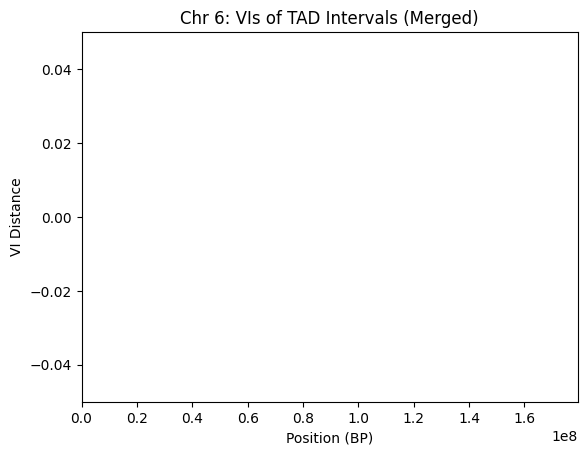

In [ ]:
chr_num = 6
# Create a figure and axis
# width = 6
# height=max(sig_vis) * 33
fig, ax = plt.subplots()

x_max = taddies[-1][-1]
y_max = max(vis_l1)

# Set axis limits based on maximum coordinates
if x_max is not None and y_max is not None:
    ax.set_xlim(0, x_max)
    ax.set_ylim(0, y_max)

# Iterate through coordinate ranges and draw rectangles
for i, (start, end) in enumerate(taddies_l1):
    x_length = (end - start) * 1 # artificial enlargment scaler
    y_length = vis_l1[i]

    # if (start < 350000) & (end > 800000):
    #     continue
    rectangle = Rectangle((start, 0), x_length, y_length, edgecolor='none', facecolor='red', alpha=0.9)
    ax.add_patch(rectangle)

# Set labels and title
ax.set_xlabel('Position (BP)')
ax.set_ylabel('VI Distance')
ax.set_title('Chr '+str(chr_num)+': VIs of TAD Intervals (Merged)')
#ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
'''
ToDo: Implement the part about identifying significant/dominant points/boudaries for p-test significance analysis stuff (section 2.4 of paper)
'''

In [ ]:
'''
ToDo: p-test and benjamini hochberg significance
'''

In [ ]:
# takes in tad lists and boundary vi values and outputs an array of boundary vi objects whe
def ComputePvals(tad_lists, boundary_vis):
